## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\benja\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [11]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[128, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 512
MOMENTUM = 0.95

In [20]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint


results = {}
call_back = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for save_best in [False, True]:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=save_best)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    key = 'save {}'.format(save_best)
    results[key] = {'train-loss': train_loss,
                    'valid-loss': valid_loss,
                    'train-acc': train_acc,
                    'valid-acc': valid_acc}

    # Load back
    model = keras.models.load_model("./tmp.h5")
    loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
    call_back[key] = {'loss': loss_loadback,
                        'acc': acc_loadback}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)               512       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               33024     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512       
__________

50000/50000 [==============================] - 8s 160us/step - loss: 0.6689 - acc: 0.7771 - val_loss: 1.6904 - val_acc: 0.4808
Epoch 50/50
10000/10000 [==============================] - 2s 173us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
batch_normalization_19 (Batc (None, 128)               512       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               33024     
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_l

50000/50000 [==============================] - 24s 473us/step - loss: 0.7061 - acc: 0.7660 - val_loss: 1.6299 - val_acc: 0.4895
Epoch 47/50
50000/50000 [==============================] - 28s 552us/step - loss: 0.6881 - acc: 0.7717 - val_loss: 1.7022 - val_acc: 0.4748
Epoch 48/50
50000/50000 [==============================] - 20s 406us/step - loss: 0.6777 - acc: 0.7751 - val_loss: 1.6749 - val_acc: 0.4847
Epoch 49/50
50000/50000 [==============================] - 25s 507us/step - loss: 0.6617 - acc: 0.7817 - val_loss: 1.6661 - val_acc: 0.4866
Epoch 50/50
10000/10000 [==============================] - 5s 470us/step


{'save False': {'loss': 1.692837762451172, 'acc': 0.4742}, 'save True': {'loss': 1.4552567781448364, 'acc': 0.4969}}


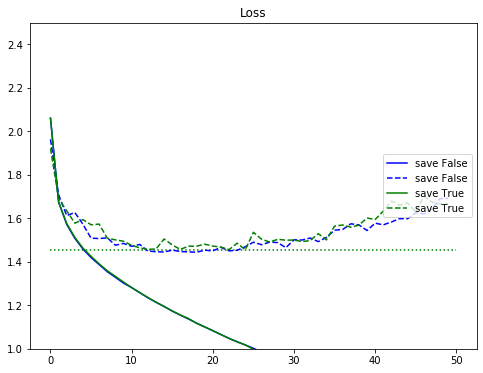

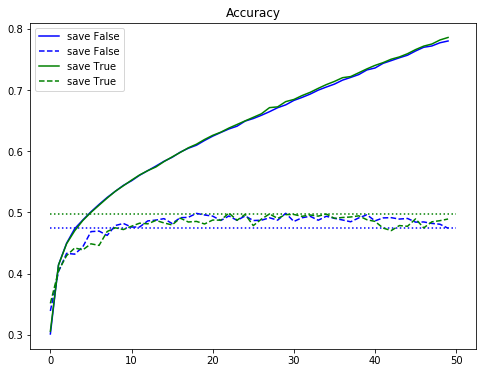

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ['b','g']

print(call_back)
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.hlines(y=call_back[cond]['loss'], xmin=0, xmax=len(train_loss), colors=color_bar[i], linestyles='dotted')
plt.ylim([1, 2.5])
plt.legend(loc='right')
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=call_back[cond]['acc'], xmin=0, xmax=len(train_loss), colors=color_bar[i], linestyles='dotted')
plt.title("Accuracy")
plt.legend()
plt.show()

In [27]:
model = keras.models.load_model("./tmp.h5")
y_pred = model.predict(x_test)

In [28]:
print(y_pred)

[[1.3793481e-02 3.0299680e-02 3.3749964e-02 ... 7.8630779e-04
  2.4873964e-02 1.5558788e-02]
 [4.1532502e-02 4.6570592e-02 1.5981777e-03 ... 1.5186308e-03
  3.3671421e-01 5.6469095e-01]
 [8.1273508e-01 3.0331673e-02 1.0547843e-02 ... 7.5730860e-02
  1.8820221e-02 4.3514356e-02]
 ...
 [3.0992870e-04 5.8540438e-05 6.5359610e-01 ... 2.9716492e-03
  2.0017775e-03 2.2396962e-04]
 [1.6270083e-01 2.1204004e-01 2.7251502e-02 ... 1.3122096e-02
  3.1845966e-01 5.6255362e-03]
 [1.9597195e-02 1.3578001e-03 2.4467461e-02 ... 5.3922713e-01
  1.4320392e-03 1.9206328e-03]]


In [ ]:
save_best會儲存設定好的monitor所表現最好的case
也可以直接從load_model讀取他